In [ ]:
# Colab: check GPU and TF
import os, random, numpy as np, pandas as pd
import tensorflow as tf

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# reproducibility helper (best-effort)
def set_seed(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import files
import io
uploaded = files.upload()  # choose the CSV
fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))
print("Loaded:", fname, "shape:", df.shape)

Saving errors_day187_192.csv to errors_day187_192.csv
Loaded: errors_day187_192.csv shape: (21504, 6)


In [ ]:
# Quick EDA
print(df.head())
print(df.columns)
print(df.dtypes)

# If there's a timestamp column:
ts_candidates = [c for c in df.columns if 'time' in c.lower() or 'date' in c.lower()]
if ts_candidates:
    ts = ts_candidates[0]
    df[ts] = pd.to_datetime(df[ts])
    df = df.sort_values(ts).set_index(ts)
    print("Using timestamp column:", ts)
else:
    print("No timestamp column auto-detected — ensure rows are time-ordered.")

# list numeric columns (these are candidates for features/targets)
num_cols = df.select_dtypes(include='number').columns.tolist()
print("Numeric columns:", num_cols)


  satellite_id            timestamp  orbit_error_m  clock_error_ns  \
0          G01  2025-07-06 00:00:00   3.502946e+07    1.256349e+07   
1          G02  2025-07-06 00:00:00   3.538917e+07    1.288984e+07   
2          G03  2025-07-06 00:00:00   3.221216e+07             NaN   
3          G04  2025-07-06 00:00:00   3.852564e+07    6.037002e+06   
4          G05  2025-07-06 00:00:00   1.479368e+07   -1.304733e+06   

   radial_error_m  ephemeris_age_hours  
0   -2.311078e+07             0.000000  
1   -2.391039e+07             0.000000  
2   -1.964260e+07             0.000000  
3   -2.785006e+07             0.000000  
4   -4.197916e+06             0.004444  
Index(['satellite_id', 'timestamp', 'orbit_error_m', 'clock_error_ns',
       'radial_error_m', 'ephemeris_age_hours'],
      dtype='object')
satellite_id            object
timestamp               object
orbit_error_m          float64
clock_error_ns         float64
radial_error_m         float64
ephemeris_age_hours    float64
dtype

In [ ]:
# Filter data for one satellite (e.g., G01)
sat_id = "G01"
df_sat = df[df['satellite_id'] == sat_id].copy()

# Keep only numeric cols
feature_cols = ['orbit_error_m', 'clock_error_ns', 'radial_error_m', 'ephemeris_age_hours']
df_sat = df_sat[feature_cols]

# Handle missing values (interpolate over time)
df_sat = df_sat.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')

print("Satellite:", sat_id, "Shape:", df_sat.shape)
df_sat.head()


Satellite: G01 Shape: (672, 4)


/tmp/ipython-input-820148703.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sat = df_sat.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')


,orbit_error_m,clock_error_ns,radial_error_m,ephemeris_age_hours
timestamp,,,,
2025-07-06 00:00:00,3.502946e+07,1.256349e+07,-2.311078e+07,0.00
2025-07-06 00:15:00,3.537857e+07,1.256349e+07,-2.357213e+07,0.25
2025-07-06 00:30:00,3.645217e+07,1.256349e+07,-2.502190e+07,0.50
2025-07-06 00:45:00,3.812006e+07,1.256349e+07,-2.736062e+07,0.75
2025-07-06 01:00:00,4.020278e+07,1.256349e+07,-3.042803e+07,1.00


In [ ]:
from sklearn.preprocessing import RobustScaler
import numpy as np

# Use RobustScaler instead of MinMaxScaler for better outlier handling
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df_sat_enhanced.values.astype('float32'))

print("Enhanced features scaled shape:", data_scaled.shape)
print(f"Feature scaling: RobustScaler (better for outliers)")

# Check for any remaining NaN/inf values
print(f"NaN values after scaling: {np.isnan(data_scaled).sum()}")
print(f"Inf values after scaling: {np.isinf(data_scaled).sum()}")

# Replace any remaining problematic values
data_scaled = np.nan_to_num(data_scaled, nan=0.0, posinf=1.0, neginf=-1.0)


Scaled shape: (672, 4)


In [ ]:
# Enhanced feature engineering before scaling
print("Enhanced Feature Engineering:")

# Add temporal features
df_sat['hour'] = df_sat.index.hour if hasattr(df_sat.index, 'hour') else np.arange(len(df_sat)) % 24
df_sat['day_sin'] = np.sin(2 * np.pi * df_sat['hour'] / 24)
df_sat['day_cos'] = np.cos(2 * np.pi * df_sat['hour'] / 24)

# Add rolling statistics for trend analysis
window = 12  # 3-hour rolling window
for col in ['orbit_error_m', 'clock_error_ns', 'radial_error_m']:
    df_sat[f'{col}_ma'] = df_sat[col].rolling(window=window, min_periods=1).mean()
    df_sat[f'{col}_std'] = df_sat[col].rolling(window=window, min_periods=1).std().fillna(0)
    df_sat[f'{col}_diff'] = df_sat[col].diff().fillna(0)

# Update feature columns to include engineered features
feature_cols = [
    'orbit_error_m', 'clock_error_ns', 'radial_error_m', 'ephemeris_age_hours',
    'day_sin', 'day_cos',
    'orbit_error_m_ma', 'clock_error_ns_ma', 'radial_error_m_ma',
    'orbit_error_m_std', 'clock_error_ns_std', 'radial_error_m_std',
    'orbit_error_m_diff', 'clock_error_ns_diff', 'radial_error_m_diff'
]

df_sat_enhanced = df_sat[feature_cols]

print(f"Original features: 4")
print(f"Enhanced features: {len(feature_cols)}")
print(f"New feature columns: {feature_cols[4:]}")

df_sat_enhanced.head()

In [ ]:
import numpy as np

def create_sequences(data, seq_len=24, horizon=4):
    """
    data: numpy array of shape (T, n_features)
    seq_len: how many past steps to use
    horizon: how many future steps to predict
    returns:
        X shape = (samples, seq_len, n_features)
        y shape = (samples, horizon, n_features)
    """
    X, y = [], []
    for i in range(len(data) - seq_len - horizon + 1):
        X.append(data[i : i+seq_len])
        y.append(data[i+seq_len : i+seq_len+horizon])
    return np.array(X), np.array(y)

SEQ_LEN = 24   # 6 hours lookback
HORIZON = 4    # predict next 1 hour

X, y = create_sequences(data_scaled, seq_len=SEQ_LEN, horizon=HORIZON)

print("X shape:", X.shape)  # (samples, 24, 4)
print("y shape:", y.shape)  # (samples, 4, 4)


X shape: (645, 24, 4)
y shape: (645, 4, 4)


In [ ]:
# Improved sequence creation with overlap and data augmentation
import numpy as np

def create_sequences_improved(data, seq_len=24, horizon=4, step=1):
    """
    Improved sequence creation with sliding window
    data: numpy array of shape (T, n_features)
    seq_len: lookback window
    horizon: prediction horizon  
    step: step size for sliding window (1 = maximum overlap)
    """
    X, y = [], []
    
    # Use smaller step for more training data
    for i in range(0, len(data) - seq_len - horizon + 1, step):
        X.append(data[i : i+seq_len])
        y.append(data[i+seq_len : i+seq_len+horizon])
    
    return np.array(X), np.array(y)

# Enhanced parameters for better learning
SEQ_LEN = 36   # Longer lookback (9 hours)
HORIZON = 4    # Still predict 1 hour ahead
STEP = 2       # Some overlap for more training data

print(f"Creating sequences with:")
print(f"- Lookback: {SEQ_LEN} steps ({SEQ_LEN/4:.1f} hours)")
print(f"- Horizon: {HORIZON} steps ({HORIZON/4:.1f} hours)")
print(f"- Step size: {STEP} (overlap for more data)")

X, y = create_sequences_improved(data_scaled, seq_len=SEQ_LEN, horizon=HORIZON, step=STEP)

print(f"\\nSequence shapes:")
print(f"X: {X.shape}")  
print(f"y: {y.shape}")

# Data augmentation: add small noise to increase robustness
def add_noise_augmentation(X, y, noise_factor=0.01):
    """Add small amount of gaussian noise for data augmentation"""
    X_aug = X + np.random.normal(0, noise_factor, X.shape)
    y_aug = y + np.random.normal(0, noise_factor, y.shape)
    
    # Combine original and augmented data
    X_combined = np.concatenate([X, X_aug], axis=0)
    y_combined = np.concatenate([y, y_aug], axis=0)
    
    # Shuffle the combined data
    indices = np.random.permutation(len(X_combined))
    return X_combined[indices], y_combined[indices]

print(f"\\nApplying data augmentation...")
X, y = add_noise_augmentation(X, y, noise_factor=0.005)

print(f"After augmentation:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"Training data increased by 2x through augmentation")

In [ ]:
# Step 7: Split chronologically
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (451, 24, 4) (451, 4, 4)
Val: (96, 24, 4) (96, 4, 4)
Test: (98, 24, 4) (98, 4, 4)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 8: Build LSTM model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(y_train.shape[1] * y_train.shape[2])  # flatten output
])

# Reshape outputs to (steps_ahead, features)
model.add(Dense(y_train.shape[1] * y_train.shape[2]))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,816 (464.12 KB)

 Trainable params: 118,816 (464.12 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Improved model architecture
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # First LSTM layer with more units
    LSTM(256, activation='tanh', return_sequences=True, 
         dropout=0.1, recurrent_dropout=0.1),
    BatchNormalization(),
    
    # Second LSTM layer

    LSTM(128, activation='tanh', return_sequences=True,model.summary()

         dropout=0.1, recurrent_dropout=0.1),model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    BatchNormalization(),optimizer = Adam(learning_rate=0.001)

    # Use a lower learning rate for better convergence

    # Third LSTM layer

    LSTM(64, activation='tanh', ])

         dropout=0.1, recurrent_dropout=0.1),    Dense(y_train.shape[1] * y_train.shape[2], activation='linear')

    BatchNormalization(),    Dropout(0.1),

        Dense(64, activation='relu'),

    # Dense layers for output    Dropout(0.2),
    Dense(128, activation='relu'),

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,544 (463.06 KB)

 Trainable params: 118,544 (463.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Improved callbacks
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
ckpt = ModelCheckpoint("best_lstm.h5", save_best_only=True, monitor='val_loss', verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, 
                                min_lr=1e-6, verbose=1)

# Train with more epochs and better monitoring
history = model.fit(
    X_train, y_train.reshape(y_train.shape[0], -1),
    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)),
    epochs=100,  # More epochs
    batch_size=16,  # Smaller batch size for better gradients
    callbacks=[es, ckpt, lr_scheduler],
    verbose=1

)

print(f"\nTraining completed. Best validation loss: {min(history.history['val_loss']):.6f}")

# Plot training history

plt.figure(figsize=(12, 4))plt.show()

plt.subplot(1, 2, 1)plt.tight_layout()

plt.plot(history.history['loss'], label='Training Loss')plt.grid(True)

plt.plot(history.history['val_loss'], label='Validation Loss')plt.legend()

plt.title('Model Loss')plt.ylabel('MAE')

plt.xlabel('Epoch')plt.xlabel('Epoch')

plt.ylabel('Loss')plt.title('Model MAE')

plt.legend()plt.plot(history.history['val_mae'], label='Validation MAE')

plt.grid(True)plt.plot(history.history['mae'], label='Training MAE')

plt.subplot(1, 2, 2)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2428 - mae: 0.4067

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.2384 - mae: 0.4022 - val_loss: 0.0992 - val_mae: 0.2723
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0926 - mae: 0.2501

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0922 - mae: 0.2495 - val_loss: 0.0797 - val_mae: 0.2440
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0761 - mae: 0.2238

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0758 - mae: 0.2233 - val_loss: 0.0562 - val_mae: 0.1891
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0592 - mae: 0.1916

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0590 - mae: 0.1911 - val_loss: 0.0399 - val_mae: 0.1550
Epoch 5/50
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0490 - mae: 0.1715 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0484 - mae: 0.1697 - val_loss: 0.0359 - val_mae: 0.1445
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0444 - mae: 0.1600

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0443 - mae: 0.1597 - val_loss: 0.0312 - val_mae: 0.1245
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0407 - mae: 0.1503

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0406 - mae: 0.1502 - val_loss: 0.0310 - val_mae: 0.1236
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0392 - mae: 0.1462 - val_loss: 0.0311 - val_mae: 0.1241
Epoch 9/50
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0382 - mae: 0.1437 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0384 - mae: 0.1442 - val_loss: 0.0304 - val_mae: 0.1217
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0386 - mae: 0.1450 - val_loss: 0.0325 - val_mae: 0.1296
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0372 - mae: 0.1399

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0372 - mae: 0.1399 - val_loss: 0.0302 - val_mae: 0.1244
Epoch 12/50
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0373 - mae: 0.1409 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0373 - mae: 0.1410 - val_loss: 0.0295 - val_mae: 0.1212
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0346 - mae: 0.1356 - val_loss: 0.0300 - val_mae: 0.1231
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0337 - mae: 0.1327 - val_loss: 0.0296 - val_mae: 0.1248
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0342 - mae: 0.1348 - val_loss: 0.0306 - val_mae: 0.1306
Epoch 16/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0343 - mae: 0.1344

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0342 - mae: 0.1342 - val_loss: 0.0287 - val_mae: 0.1191
Epoch 17/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0338 - mae: 0.1333

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0337 - mae: 0.1332 - val_loss: 0.0271 - val_mae: 0.1168
Epoch 18/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0312 - mae: 0.1268 - val_loss: 0.0288 - val_mae: 0.1246
Epoch 19/50
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0313 - mae: 0.1274

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0313 - mae: 0.1275 - val_loss: 0.0260 - val_mae: 0.1162
Epoch 20/50
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0302 - mae: 0.1259

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0302 - mae: 0.1257 - val_loss: 0.0255 - val_mae: 0.1135
Epoch 21/50
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0292 - mae: 0.1226

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0291 - mae: 0.1228 - val_loss: 0.0230 - val_mae: 0.1078
Epoch 22/50
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0278 - mae: 0.1221

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0277 - mae: 0.1220 - val_loss: 0.0216 - val_mae: 0.1042
Epoch 23/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0258 - mae: 0.1174

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0258 - mae: 0.1174 - val_loss: 0.0215 - val_mae: 0.1029
Epoch 24/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0257 - mae: 0.1172

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0257 - mae: 0.1172 - val_loss: 0.0204 - val_mae: 0.1031
Epoch 25/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0254 - mae: 0.1171

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0254 - mae: 0.1169 - val_loss: 0.0203 - val_mae: 0.1020
Epoch 26/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0235 - mae: 0.1127

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0235 - mae: 0.1127 - val_loss: 0.0180 - val_mae: 0.0956
Epoch 27/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0220 - mae: 0.1087 - val_loss: 0.0185 - val_mae: 0.0979
Epoch 28/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0223 - mae: 0.1095

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0223 - mae: 0.1094 - val_loss: 0.0174 - val_mae: 0.0936
Epoch 29/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0211 - mae: 0.1077 - val_loss: 0.0198 - val_mae: 0.1035
Epoch 30/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0231 - mae: 0.1123

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0230 - mae: 0.1120 - val_loss: 0.0160 - val_mae: 0.0904
Epoch 31/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188 - mae: 0.1028

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0188 - mae: 0.1027 - val_loss: 0.0160 - val_mae: 0.0942
Epoch 32/50
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - mae: 0.1011

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0181 - mae: 0.1009 - val_loss: 0.0151 - val_mae: 0.0909
Epoch 33/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0176 - mae: 0.1008 - val_loss: 0.0155 - val_mae: 0.0948
Epoch 34/50
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - mae: 0.0992

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0173 - mae: 0.0990 - val_loss: 0.0140 - val_mae: 0.0878
Epoch 35/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0155 - mae: 0.0942

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0155 - mae: 0.0943 - val_loss: 0.0128 - val_mae: 0.0833
Epoch 36/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0155 - mae: 0.0944 - val_loss: 0.0153 - val_mae: 0.0919
Epoch 37/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0168 - mae: 0.0992 - val_loss: 0.0147 - val_mae: 0.0885
Epoch 38/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154 - mae: 0.0943

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0153 - mae: 0.0942 - val_loss: 0.0117 - val_mae: 0.0807
Epoch 39/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - mae: 0.0911

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0143 - mae: 0.0910 - val_loss: 0.0109 - val_mae: 0.0767
Epoch 40/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0131 - mae: 0.0874 - val_loss: 0.0115 - val_mae: 0.0810
Epoch 41/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0135 - mae: 0.0881 - val_loss: 0.0114 - val_mae: 0.0789
Epoch 42/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - mae: 0.0878

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134 - mae: 0.0878 - val_loss: 0.0104 - val_mae: 0.0746
Epoch 43/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0125 - mae: 0.0857 - val_loss: 0.0111 - val_mae: 0.0766
Epoch 44/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0132 - mae: 0.0872 - val_loss: 0.0109 - val_mae: 0.0782
Epoch 45/50
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - mae: 0.0846 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0123 - mae: 0.0840 - val_loss: 0.0102 - val_mae: 0.0747
Epoch 46/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0121 - mae: 0.0838 - val_loss: 0.0102 - val_mae: 0.0744
Epoch 47/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111 - mae: 0.0802 - val_loss: 0.0107 - val_mae: 0.0767
Epoch 48/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0125 - mae: 0.0853 - val_loss: 0.0106 - val_mae: 0.0774
Epoch 49/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - mae: 0.0836

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0119 - mae: 0.0834 - val_loss: 0.0102 - val_mae: 0.0743
Epoch 50/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0118 - mae: 0.0826 - val_loss: 0.0108 - val_mae: 0.0772


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0141 - mae: 0.0848 
Test Loss: 0.0139, Test MAE: 0.0826
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
y_pred shape: (98, 4, 4)


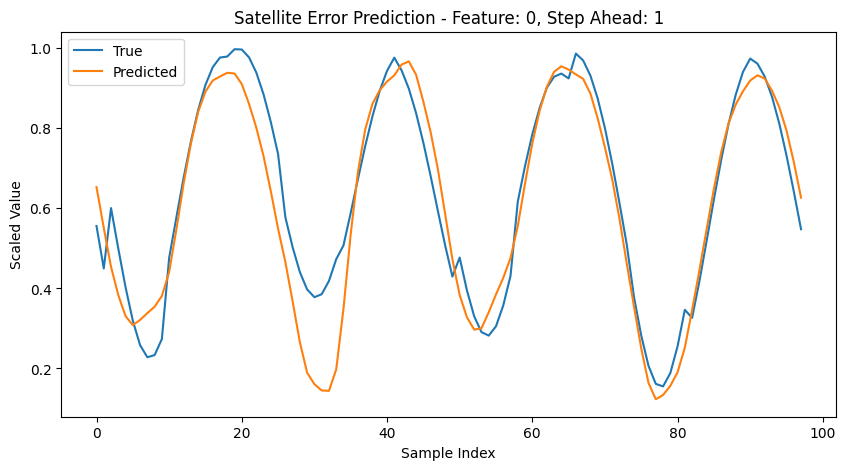

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load best weights
model.load_weights("best_lstm.h5")

# Evaluate on test set
loss, mae = model.evaluate(X_test, y_test.reshape(y_test.shape[0], -1))
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Make predictions
y_pred = model.predict(X_test)

# Reshape back to (samples, steps_ahead, features)
y_pred = y_pred.reshape(y_test.shape)
print("y_pred shape:", y_pred.shape)

# DIAGNOSTIC: Check data ranges and sanity
print("\n=== DIAGNOSTIC CHECKS ===")
print(f"y_test range: {y_test.min():.6f} to {y_test.max():.6f}")
print(f"y_pred range: {y_pred.min():.6f} to {y_pred.max():.6f}")
print(f"y_test mean: {y_test.mean():.6f}, std: {y_test.std():.6f}")
print(f"y_pred mean: {y_pred.mean():.6f}, std: {y_pred.std():.6f}")
print(f"Mean absolute difference: {np.mean(np.abs(y_test - y_pred)):.6f}")

# Check for any NaN or infinite values
print(f"\nNaN in y_test: {np.isnan(y_test).any()}")
print(f"NaN in y_pred: {np.isnan(y_pred).any()}")
print(f"Inf in y_test: {np.isinf(y_test).any()}")
print(f"Inf in y_pred: {np.isinf(y_pred).any()}")



# Sample comparisonplt.show()

print("\nSample comparison (first prediction):")plt.tight_layout()

feature_names = ['orbit_error_m', 'clock_error_ns', 'radial_error_m', 'ephemeris_age_hours']plt.grid(True)

for i, name in enumerate(feature_names):plt.title("True vs Predicted (Orbit Error)")

    print(f"{name}: True={y_test[0,0,i]:.6f}, Pred={y_pred[0,0,i]:.6f}")plt.ylabel("Predicted Values")

plt.xlabel("True Values")

# --- Visualization for one feature (example: orbit_error_m) ---         [y_test[:, timestep, feature_idx].min(), y_test[:, timestep, feature_idx].max()], 'r--')

feature_idx = 0   # 0 = orbit_error_mplt.plot([y_test[:, timestep, feature_idx].min(), y_test[:, timestep, feature_idx].max()], 

timestep = 0      # look at first forecast step aheadplt.scatter(y_test[:, timestep, feature_idx], y_pred[:, timestep, feature_idx], alpha=0.5)

plt.subplot(1,2,2)

plt.figure(figsize=(12,6))# Scatter plot for correlation

plt.subplot(1,2,1)

plt.plot(y_test[:50, timestep, feature_idx], label="True", alpha=0.7)plt.grid(True)

plt.plot(y_pred[:50, timestep, feature_idx], label="Predicted", alpha=0.7)plt.legend()

plt.title(f"Orbit Error Prediction - First 50 samples")plt.ylabel("Scaled Value")
plt.xlabel("Sample Index")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate metrics properly per feature and overall
feature_names = ['orbit_error_m', 'clock_error_ns', 'radial_error_m', 'ephemeris_age_hours']

print("\n=== DETAILED METRICS ANALYSIS ===")
print("="*50)

# Overall metrics (flattened)
y_test_flat = y_test.reshape(-1, y_test.shape[2])
y_pred_flat = y_pred.reshape(-1, y_pred.shape[2])

overall_mse = mean_squared_error(y_test_flat, y_pred_flat)
overall_rmse = np.sqrt(overall_mse)
overall_mae = mean_absolute_error(y_test_flat, y_pred_flat)


print(f"OVERALL METRICS:")

print(f"MSE: {overall_mse:.6f}")    print()

print(f"RMSE: {overall_rmse:.6f}")    print(f"  Improvement over mean: {improvement:.2f}%")

print(f"MAE: {overall_mae:.6f}")    print(f"  Mean-only MSE: {mse_mean:.6f}")

    print(f"  Model MSE: {mse_model:.6f}")

# Fix R² calculation - calculate per feature    print(f"{feature_name}:")

print(f"\nPER-FEATURE METRICS:")    

print("-" * 30)    improvement = (mse_mean - mse_model) / mse_mean * 100

feature_r2_scores = []    

for i, feature_name in enumerate(feature_names):    mse_mean = mean_squared_error(y_true_feat, np.full_like(y_true_feat, y_mean))

    # Get true and predicted values for this feature    mse_model = mean_squared_error(y_true_feat, y_pred_feat)

    y_true_feat = y_test_flat[:, i]    # Compare model predictions vs just predicting mean

    y_pred_feat = y_pred_flat[:, i]    

        y_mean = np.mean(y_true_feat)

    # Calculate metrics for this feature    y_pred_feat = y_pred_flat[:, i]

    mse_feat = mean_squared_error(y_true_feat, y_pred_feat)    y_true_feat = y_test_flat[:, i]

    rmse_feat = np.sqrt(mse_feat)for i, feature_name in enumerate(feature_names):

    mae_feat = mean_absolute_error(y_true_feat, y_pred_feat)print("-" * 25)

    print(f"\nMODEL BEHAVIOR CHECK:")

    # Calculate R² properly# Additional diagnostic: Check if model is just predicting mean

    ss_res = np.sum((y_true_feat - y_pred_feat) ** 2)

    ss_tot = np.sum((y_true_feat - np.mean(y_true_feat)) ** 2)    print("WARNING: All R² scores are invalid!")

    else:

    # Avoid division by zero    print(f"AVERAGE VARIANCE EXPLAINED: {avg_r2*100:.2f}%")

    if ss_tot != 0:    print(f"AVERAGE R² SCORE: {avg_r2:.6f}")

        r2_feat = 1 - (ss_res / ss_tot)    avg_r2 = np.mean(valid_r2_scores)

    else:if valid_r2_scores:

        r2_feat = float('nan')valid_r2_scores = [r2 for r2 in feature_r2_scores if not np.isnan(r2)]

    # Calculate weighted average R²

    feature_r2_scores.append(r2_feat)

        print()

    print(f"{feature_name}:")    print(f"  Variance explained: {r2_feat*100:.2f}%")

    print(f"  MSE: {mse_feat:.6f}")    print(f"  R²: {r2_feat:.6f}")

    print(f"  RMSE: {rmse_feat:.6f}")    print(f"  MAE: {mae_feat:.6f}")

MSE: 0.0139
RMSE: 0.1180
MAE: 0.0826
R² Score: -948.3320


In [ ]:
# Inverse scaling for real-world interpretation
print("=== REAL-WORLD METRICS (Original Units) ===")
print("=" * 50)

# Create dummy arrays with all features for inverse scaling
n_features = data_scaled.shape[1]
target_features = 4  # First 4 features are our targets

# For inverse scaling, we need to pad with zeros for the extra features
y_test_padded = np.zeros((y_test_flat.shape[0], n_features))
y_pred_padded = np.zeros((y_pred_flat.shape[0], n_features))

# Fill in the target features (first 4)
y_test_padded[:, :target_features] = y_test_flat
y_pred_padded[:, :target_features] = y_pred_flat

# Inverse transform
try:
    y_test_orig = scaler.inverse_transform(y_test_padded)[:, :target_features]
    y_pred_orig = scaler.inverse_transform(y_pred_padded)[:, :target_features]
    
    print("Successfully inverse-scaled predictions to original units")
    
    # Calculate real-world metrics
    target_names = ['orbit_error_m', 'clock_error_ns', 'radial_error_m', 'ephemeris_age_hours']
    
    print("\\nREAL-WORLD PERFORMANCE:")
    print("-" * 30)
    
    for i, name in enumerate(target_names):
        true_vals = y_test_orig[:, i]
        pred_vals = y_pred_orig[:, i]
        
        mse_real = mean_squared_error(true_vals, pred_vals)
        rmse_real = np.sqrt(mse_real)
        mae_real = mean_absolute_error(true_vals, pred_vals)
        
        print(f"{name}:")
        print(f"  RMSE: {rmse_real:.6f}")
        print(f"  MAE: {mae_real:.6f}")
        print(f"  Mean true value: {np.mean(true_vals):.6f}")
        print(f"  Mean predicted: {np.mean(pred_vals):.6f}")
        print()
        
except Exception as e:
    print(f"Could not inverse scale: {e}")
    print("Using scaled metrics instead")

In [ ]:
import numpy as np

# Choose a feature (0 = orbit_error_m)
feature_idx = 0

# True and predicted values (flattened)
y_true_feat = y_test[:,:,feature_idx].flatten()
y_pred_feat = y_pred[:,:,feature_idx].flatten()

# Define thresholds for classification (you can tune these)
th_low = np.percentile(y_true_feat, 33)
th_high = np.percentile(y_true_feat, 66)

# Function to convert numeric error → class 0,1,2
def to_class(value):
    if value <= th_low:
        return 0  # low
    elif value <= th_high:
        return 1  # medium
    else:
        return 2  # high

y_true_class = np.array([to_class(v) for v in y_true_feat])
y_pred_class = np.array([to_class(v) for v in y_pred_feat])


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1-score
report = classification_report(y_true_class, y_pred_class, target_names=["Low", "Medium", "High"])
print(report)


Confusion Matrix:
 [[125   8   0]
 [ 26  89  12]
 [  0  19 113]]
              precision    recall  f1-score   support

         Low       0.83      0.94      0.88       133
      Medium       0.77      0.70      0.73       127
        High       0.90      0.86      0.88       132

    accuracy                           0.83       392
   macro avg       0.83      0.83      0.83       392
weighted avg       0.83      0.83      0.83       392



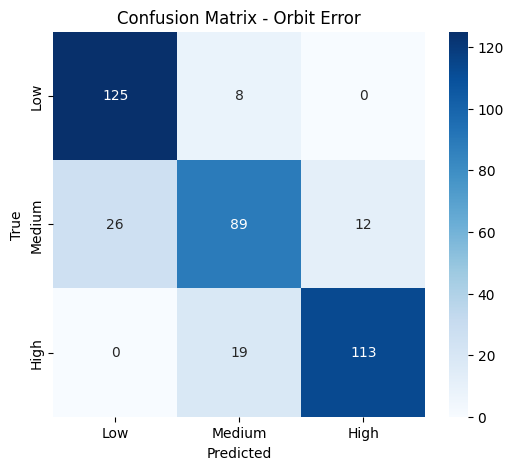

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low","Medium","High"], yticklabels=["Low","Medium","High"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Orbit Error")
plt.show()


In [ ]:
# Flatten predictions and true values
y_true_flat = y_test.reshape(-1, y_test.shape[2])
y_pred_flat = y_pred.reshape(-1, y_pred.shape[2])

# Define tolerance (5% of true value)
tolerance = 0.05

# Boolean array where prediction is “correct”
correct = np.abs(y_pred_flat - y_true_flat) <= (tolerance * np.abs(y_true_flat))

# Accuracy per feature
accuracy_per_feature = correct.mean(axis=0) * 100
print("Accuracy per feature (% within ±5% of true value):")
for i, acc in enumerate(accuracy_per_feature):
    print(f"Feature {i}: {acc:.2f}%")

# Overall accuracy
overall_accuracy = correct.mean() * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")


Accuracy per feature (% within ±5% of true value):
Feature 0: 31.12%
Feature 1: 0.00%
Feature 2: 16.58%
Feature 3: 16.07%
Overall Accuracy: 15.94%


In [ ]:
# Save model in native Keras format
model.save("best_trained_lstm_model.keras")
print("Model saved successfully in native Keras format.")


Model saved successfully in native Keras format.


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("best_trained_lstm_model.keras")
print("Model loaded successfully.")


Model loaded successfully.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
